In [1]:
# Define a function that generates samples approximate RGO. The target is defined in Potential class.
import numpy as np
import matplotlib.pyplot as plt
import targets
import cProfile
import pstats
import random
import argparse
import os
from utils import  mixing_time, TV_estimation, target_MixedGaussian, target_funnel
import matplotlib.ticker as ticker


In [2]:

def estimate_D(step_size, y, f, size = 10):
    dimension = f.dimension
    # Compute the desired sub-exponential parameter
    x_y = f.solve1(y, step_size)
    testFunction = lambda C : np.mean(np.exp(np.abs(Y)**(2/(1+f.alpha))/C))-2
    # Generate random samples from a Gaussian distribution: \exp^{-(x-x_y)^2/(2\step_size)}
    samples = np.random.multivariate_normal(mean = x_y, cov = step_size * np.identity(dimension), size = size*2)
    Y = np.zeros(size)
    for i in range(size):
        gradient = f.firstOrder(x_y)
        a = f.zeroOrder(samples[i])-np.dot(gradient,samples[i])
        b = f.zeroOrder(samples[i+size])-np.dot(gradient,samples[i+size])
        Y[i] = b-a
    # Estimate the sub-exponential parameter of Y: find the smallest C>0 such that E[\exp^{\abs(Y)/C}] \leq 2 by binary search for smooth potentials
    # Initialize the interval
    left = 0
    right = dimension**(f.alpha/(f.alpha+1)) # The estimated upper bound of the sub-exponential parameter
    while testFunction(right)>0:
        left = right
        right = 2*right
    # Initialize the middle point
    mid = (left+right)/2
    # Initialize the value of the function
    f_mid = testFunction(mid)
    while abs(f_mid) > 1e-1:
        if f_mid > 0:
            left = mid
        else:
            right = mid
        mid = (left+right)/2
        f_mid =  testFunction(mid)
    return mid

/usr/local/lib/python3.9/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3.189123441819203e-06


/usr/local/lib/python3.9/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


3.3468150556274226e-07


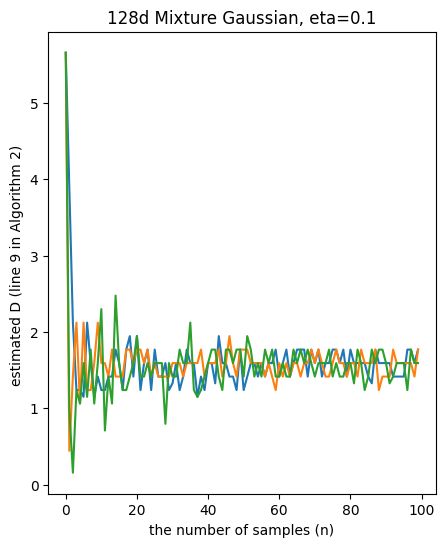

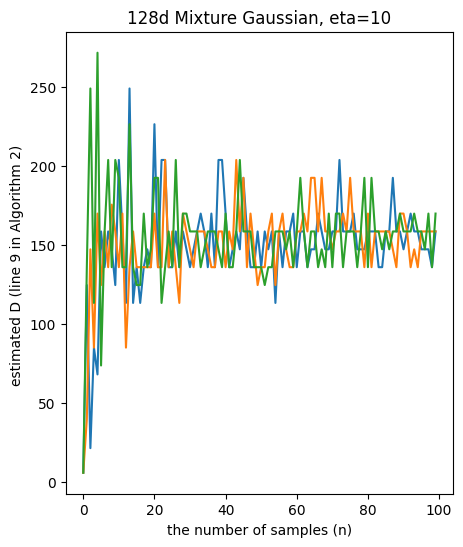

In [3]:
plt.figure(figsize=(5, 6))
dimension = 128
Target, _ = target_MixedGaussian(dimension)
ys = np.random.multivariate_normal(mean = np.zeros(dimension), cov = np.identity(dimension), size = 3)
for y in ys:
    estimated_one = []
    for i in range(100):
        estimated_one.append(estimate_D(step_size=0.1, y = y, f = Target, size = i))
    plt.plot(estimated_one)
plt.xlabel('the number of samples (n)')
plt.ylabel('estimated D (line 9 in Algorithm 2) ')
plt.title('128d Mixture Gaussian, eta=0.1')
plt.savefig('stable_MixtureGaussian.pdf')

plt.figure(figsize=(5, 6))
dimension = 128
Target, _ = target_MixedGaussian(dimension)
ys = np.random.multivariate_normal(mean = np.zeros(dimension), cov = np.identity(dimension), size = 3)
for y in ys:
    estimated_one = []
    for i in range(100):
        estimated_one.append(estimate_D(step_size=10, y = y, f = Target, size = i))
    plt.plot(estimated_one)
plt.xlabel('the number of samples (n)')
plt.ylabel('estimated D (line 9 in Algorithm 2) ')
plt.title('128d Mixture Gaussian, eta=10')
plt.savefig('stable_MixtureGaussian_large.pdf')

/usr/local/lib/python3.9/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


8.90530906533736e-07
8.90530906533736e-07
2.781615622102236e-06


/usr/local/lib/python3.9/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7.96945093613706e-06
1.0390493104184621e-05
1.0390493104184621e-05


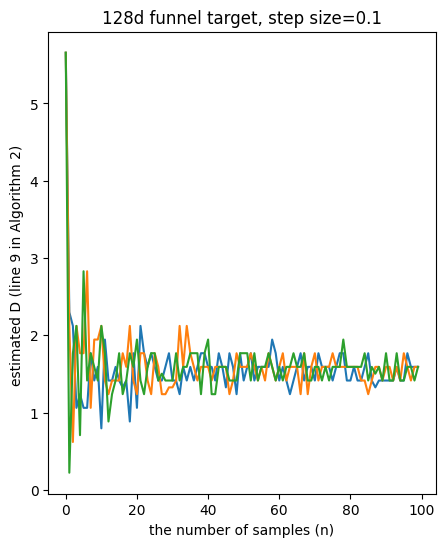

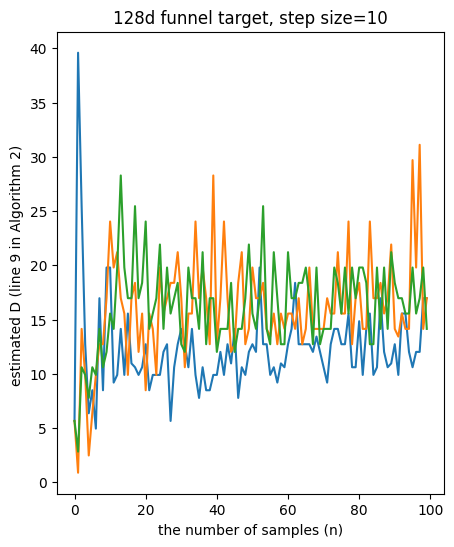

In [4]:
# estimated D is unstable for large step size, for instance, 20 for Gaussian and funnel
plt.figure(figsize=(5, 6))
dimension = 128
Target, _ = target_MixedGaussian(dimension)
ys = np.random.multivariate_normal(mean = np.zeros(dimension), cov = np.identity(dimension), size = 3)
for y in ys:
    estimated_one = []
    for i in range(100):
        estimated_one.append(estimate_D(step_size=0.1, y = y, f = Target, size = i))
    plt.plot(estimated_one)
plt.xlabel('the number of samples (n)')
plt.ylabel('estimated D (line 9 in Algorithm 2) ')
plt.title('128d funnel target, step size=0.1')
plt.savefig('stable_funnel.pdf')

plt.figure(figsize=(5, 6))
dimension = 128
Target = target_funnel(dimension)
ys = np.random.multivariate_normal(mean = np.zeros(dimension), cov = np.identity(dimension), size = 3)
for y in ys:
    estimated_one = []
    for i in range(100):
        estimated_one.append(estimate_D(step_size=1, y = y, f = Target, size = i))
    plt.plot(estimated_one)
plt.xlabel('the number of samples (n)')
plt.ylabel('estimated D (line 9 in Algorithm 2) ')
plt.title('128d funnel target, step size=10')
plt.savefig('stable_funnel_large.pdf')